## Wave eqution with open boundaries and PT potential 
The idea is to 'simulate' scattering of the wave on a potential

In [13]:
import numpy as np
import matplotlib.pyplot as plt

#### Class with statics -- RHS of the wave equation with the potential for 2nd and 4th order accuracy

In [14]:
class RHS:
    """
        Different RHS for wave equation for
        2nd and 4th order accuracy finite differencing
    """

    @staticmethod
    def rhs_stencil2(u, xs, v, nr, ng):
        N = nr + 2 * ng  # grid size including ghosts
        dotu = np.zeros_like(u)  # rhs

        z = u[0:N]  # reference
        s = u[N:2 * N]
        dotz = dotu[0:N]  # reference
        dots = dotu[N:2 * N]
        d2z = np.zeros_like(z)  # mem for drvt

        drs = xs[1] - xs[0]
        idx = 1. / drs

        i = 0
        z[i] = z[i + 2] - 2 * drs * s[i + 1]
        s[i] = 2 * s[i + 1] - s[i + 2]

        i = N - 1
        z[i] = z[i - 2] - 2 * drs * s[i - 1]
        s[i] = 2 * s[i - 1] - s[i - 2]

        i = np.arange(1, nr + 1)
        # Wiki: -1/12 * z[i-2] + 4/3 * z[i-1] -5/2 * z[i] + 4/3 * z[i+1] - 1/12 * z[i+2]
        d2z[i] = idx * idx * (z[i+1] + z[i-1] - 2 * z[i])
        dotz[i] = s[i]
        dots[i] = d2z[i] + z[i] * v[i]
        # print(dotu); exit(1)
        return dotu

    @staticmethod
    def rhs_stencil4(u, xs, v, nr, ng):
        """
        :param u: state vector u[0:N] - function, u[N:2N] - its derivative
        :return:
        """
        N = nr + 2 * ng  # grid size including ghosts
        dotu = np.zeros_like(u)  # rhs

        z = u[0:N]  # reference
        s = u[N:2 * N]
        dotz = dotu[0:N]  # reference
        dots = dotu[N:2 * N]
        d2z = np.zeros_like(z)  # mem for drvt

        drs = xs[1] - xs[0]
        factdrs2 = 1. / (12. * drs * drs)
        othree = 1. / 3.

        i = 1
        z[i] = - 4. * drs * s[i + 1] - 10. * othree * z[i + 1] + 6. * z[i + 2] - 2. * z[i + 3] + othree * z[i + 4]

        i = N - 2
        z[i] = - 4. * drs * s[i - 1] - 10. * othree * z[i - 1] + 6. * z[i - 2] - 2. * z[i - 3] + othree * z[i - 4]

        i = 0
        # z[i] = - 20.*drs*s[i+2] - 80.*othree*z[i+2] + 40.*z[i+3] - 15.*z[i+4] + 8.*othree*z[i+5]   --   32
        z[i] = + 5. * z[i + 1] - 10. * z[i + 2] + 10. * z[i + 3] - 5. * z[i + 4] + z[i + 5]
        # z[i] = - 20 * s[i + 2] - (80/3.) * z[i + 3] + 40 * z[i + 4] - 15. * z[i + 5] + (8/3.) * z[i+6]

        i = N - 1
        # z[i] = - 20.*drs*s[i-2] - 80.*othree*z[i-2] + 40.*z[i-3] - 15.*z[i-4] + 8.*othree*z[i-5]   --   32
        z[i] = + 5 * z[i - 1] - 10. * z[i - 2] + 10. * z[i - 3] - 5. * z[i - 4] + z[i - 5]
        # z[i] = 20 * s[i - 2] - (80 / 3.) * z[i - 3] + 40 * z[i - 4] - 15. * z[i -5] + (8 / 3.) * z[i - 6]

        # u = (z,s)
        # z,t = s
        # s,t = z,xx + V z
        i = np.arange(2, nr + 2)
        # Wiki: -1/12 * z[i-2] + 4/3 * z[i-1] -5/2 * z[i] + 4/3 * z[i+1] - 1/12 * z[i+2]
        d2z[i] = (16. * (z[i + 1] + z[i - 1]) - 30. * z[i] - (z[i + 2] + z[i - 2])) * factdrs2
        dotz[i] = s[i]
        dots[i] = d2z[i] + z[i] * v[i]

        # print(dotu); exit(1)
        return dotu


#### standard time integrator

In [15]:
def RK4(dt, u, rhs, pars):
    """
    Runge-Kutta 4
    """
    # storage
    utmp = np.zeros_like(u)
    # shorthand
    halfdt = 0.5 * dt
    dt6 = dt / 6.
    # time = n*dt
    # steps
    k1 = rhs(u, *pars)
    utmp[:] = u[:] + halfdt * k1[:]
    k2 = rhs(utmp, *pars)
    utmp[:] = u[:] + halfdt * k2[:]
    k3 = rhs(utmp, *pars)
    utmp[:] = u[:] + dt * k3[:]
    k4 = rhs(utmp, *pars)
    u[:] = u[:] + dt6 * (k1[:] + 2. * (k2[:] + k3[:]) + k4[:])
    return u

#### The PT potential, e.g. https://en.wikipedia.org/wiki/P%C3%B6schl%E2%80%93Teller_potential

In [16]:
def PT_potential(xarr):
    """
    standart formula for PT potential, where hyperbolic sin
    is expressed as exponentials
    :param xarr:
    :return:
    """

    beta = 0#1j * 1 * np.pi / 2
    kappa = 0.1#0.1
    v0 = 0.15#0.15
    V = v0 * ((np.exp(kappa * xarr + beta) - np.exp(-kappa * xarr - beta)) /
              (np.exp(kappa * xarr + beta) + np.exp(-kappa * xarr - beta))) ** 2 - v0

    return V

#### initial data -- gaussian packet

In [17]:
def gaussian_packet(x, Rps, dsigma, timesym=0.):
    """
    Gaussian packet initial data
    """
    d2sigma = dsigma * dsigma
    norm = dsigma / np.sqrt(2.0 * np.pi)
    gauss = norm * np.exp(-0.5 * d2sigma * (x - Rps) ** 2)
    dgauss = -(x - Rps) * d2sigma * gauss * timesym
    return gauss, dgauss

### 'Main function' -- solver for the Wave equation

In [21]:
def solver(xmin=-300., xmax=300.,
           nx=401, cfl=0.5, tend=600., itout=(1,10), isout=2,
           indexdet=400, stencilorder=2,
           potential=True, return_full=False):
    """
        Solves the wave equation evolution for given parameters
        outputs either solution at a detector or full solution on the grid
    """

    if stencilorder == 2:
        rhs = RHS.rhs_stencil2
        ng = 1
    elif stencilorder == 4:
        rhs = RHS.rhs_stencil4
        ng = 2

    # shifting the detector with respect to ng
    indexdet = indexdet + ng

    # grid
    alln = nx + 2 * ng  # all points of a grid
    dxs = (xmax - xmin) / float(nx - 1)  # grid spacing
    xs = -2. * dxs + xmin + dxs * np.arange(alln)  # all spatial grid (+ghosts)
    dt = cfl * dxs  # time step
    u = np.zeros(2 * alln)  # solution vector. u[:N] = solution, u[N:2N] = its derivative

    # potential
    if potential: v = PT_potential(xs)
    else: v = np.zeros_like(xs)

    # initial data
    u[0:alln], u[alln:2 * alln] = gaussian_packet(xs, Rps=150., dsigma=0.25, timesym=0.)

    # main loop
    t = 0
    i = 0

    solution_det = []
    solution = []
    solution_t = []
    while t < tend:
        # print("t:{:07d} t:{:.4e} / {:.4e}".format(i, t, tend))
        if i % itout[0] == 0:
            # output solution at a detector
            z = u[0:alln]
            s = u[alln:2 * alln]
            solution_det.append([t, z[indexdet], s[indexdet]])
        if i % itout[1] == 0:
            # output solution on a grid
            z = u[0:alln]
            solution.append(np.copy(z[ng:-ng:isout]))
            solution_t.append(t)
        i = i + 1
        t = i * dt
        u = RK4(dt, u, rhs, (xs, v, nx, ng))

    solution_det = np.vstack((solution_det))
    solution = np.vstack((solution))

    if return_full:
        # full solution for every timestep on the whole grid
        return (np.array(solution_t), xs[ng:-ng:isout], solution)
    else:
        # solution at a given point (extraction) at every timestep
        return (solution_det[:, 0], solution_det[:, 1], solution_det[:, 2])

### Applications and tests
#### Task 1. Self convergence for non-potential case of this code

low:200 med:200 high:200


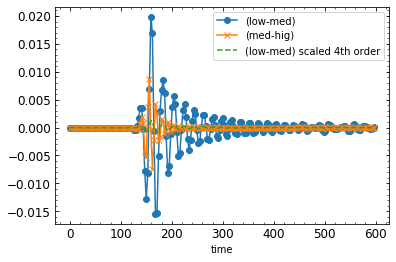

In [22]:
def self_convergence():


    tl, low, pi1 = solver(xmin=-300., xmax=300., nx=101, cfl=0.5, tend=600., itout=(1,10),
                        indexdet=50, stencilorder=4, potential=False)
    tm, med, pi2 = solver(xmin=-300., xmax=300., nx=201, cfl=0.5, tend=600., itout=(2,20),
                        indexdet=100, stencilorder=4, potential=False)
    th, hig, pi3 = solver(xmin=-300., xmax=300., nx=401, cfl=0.5, tend=600., itout=(4,10),
                        indexdet=200, stencilorder=4, potential=False)

    # pick solution at detectors x=0.

    print("low:{} med:{} high:{}".format(len(low), len(med), len(hig)))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(tl, low - med, 'o-', label="(low-med)")
    ax.plot(tm, med - hig, 'x-', label="(med-hig)")
    ax.plot(th, (low - med) / 16., '--', label="(low-med) scaled 4th order")
    ax.set_xlabel('time')
    ax.tick_params(
        axis='both', which='both', labelleft=True,
        labelright=False, tick1On=True, tick2On=True,
        labelsize=int(12),
        direction='in',
        bottom=True, top=True, left=True, right=True
    )
    # ax.set_yscale("log")
    ax.minorticks_on()
    ax.legend()
    plt.show()
self_convergence()

#### Task 2. Full solution at several timesteps, overapping 

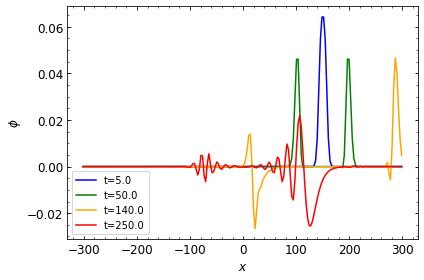

In [24]:
def find_nearest_index(array, value):
    ''' Finds index of the value in the array that is the closest to the provided one '''
    idx = (np.abs(array - value)).argmin()
    return idx

def plot_solution_at_times():
    list_times = [5., 50., 140., 250.]
    colors = ["blue", "green", "orange", "red"]
    times, xs, sols = solver(xmin=-300., xmax=300.,
                               nx=401, cfl=0.5, tend=600., itout=(1, 5), isout=2,
                               indexdet=400, stencilorder=2,
                               potential=True, return_full=True)

    fig, ax = plt.subplots(nrows=1, ncols=1)

    for t, color in zip(list_times, colors):
        idx = find_nearest_index(times, t)
        ax.plot(xs, sols[idx, :], color=color, ls='-', label='t={}'.format(t))

    ax.tick_params(
                axis='both', which='both', labelleft=True,
                labelright=False, tick1On=True, tick2On=True,
                labelsize=int(12),
                direction='in',
                bottom=True, top=True, left=True, right=True
            )

    ax.set_xlabel("$x$", fontsize='large')
    ax.set_ylabel("$\phi$", fontsize='large')
    ax.legend(loc="lower left", ncol=1)
    ax.minorticks_on()
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.0)
    plt.savefig("./profiles.png", dpi=128)
    plt.show()
plot_solution_at_times()

#### Task 2.2 Full solution at several timesteps -- 3D picture

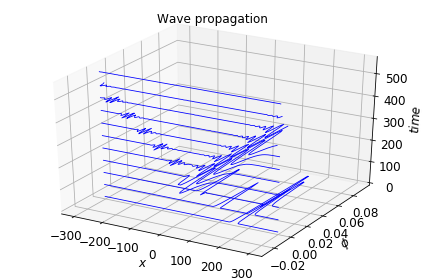

In [25]:
def plot_solution_3d():
    plot_every = 15

    times, xs, sols = solver(xmin=-300., xmax=300.,
                             nx=401, cfl=0.5, tend=600., itout=(1, 5), isout=2,
                             indexdet=400, stencilorder=2,
                             potential=True, return_full=True)

    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    for t in times[::plot_every]:
        idx = find_nearest_index(times, t)
        z = np.zeros(xs.shape)
        z.fill(times[idx])
        # print("plotting t:{}".format(time))
        ax.plot(xs, sols[idx, :], z, color="blue", ls='-', lw=0.8)

    ax.legend(loc='lower left', shadow=False, fontsize='large', frameon=False)
    # ax.set_yscale("log")
    ax.set_xlabel("$x$", fontsize='large')
    ax.set_ylabel("$\phi$", fontsize='large')
    ax.set_zlabel("$time$", fontsize='large')
    # ax.set_ylabel()
    ax.tick_params(
        axis='both', which='both', labelleft=True,
        labelright=False, tick1On=True, tick2On=True,
        labelsize=int(12),
        direction='in',
        bottom=True, top=True, left=True, right=True
    )
    ax.minorticks_on()
    ax.set_title("Wave propagation")
    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)
    plt.savefig("./wave_3d.png", dpi=128)
    plt.tight_layout()
    plt.show()
plot_solution_3d()

#### Task 3. Solution evolution at a detector

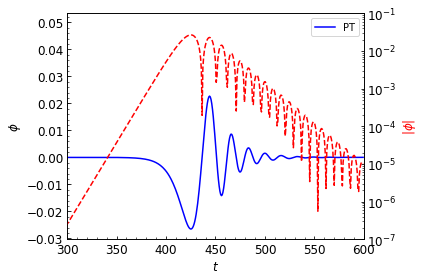

In [28]:
def task_solve_pt_plot():

    t, phi, pi = solver(xmin=-300., xmax=300.,
                        nx=401, cfl=0.5, tend=600., itout=(1,10),
                        indexdet=400, stencilorder=4)

    fig, ax1 = plt.subplots()
    ax1.plot(t, phi, '-', color='blue', label='PT')
    ax1.set_xlabel(r'$t$', fontsize='large')
    ax1.set_ylabel(r'$\phi$', fontsize='large')
    ax1.legend()
    ax1.tick_params(
        axis='both', which='both', labelleft=True,
        labelright=False, tick1On=True, tick2On=False,
        labelsize=int(12),
        direction='in',
        bottom=True, top=True, left=True, right=True
    )
    ax1.minorticks_on()

    ax2 = ax1.twinx()
    ax2.semilogy(t, np.fabs(phi), '--', color='red')
    ax2.set_ylabel(r'$|\phi|$', fontsize='large', color="red")
    # ax1.set_ylim([-0.04,0.05])
    ax2.set_ylim([1e-7, 1e-1])
    ax2.tick_params(
        axis='both', which='both', labelleft=False,
        labelright=True, tick1On=False, tick2On=True,
        labelsize=int(12),
        direction='in',
        bottom=True, top=True, left=True, right=True
    )
    ax2.minorticks_on()

    plt.xlim([300, 600])
    fig.tight_layout()
    # plt.savefig(FIGPATH+"extracted_at_x402.png")
    plt.show()
task_solve_pt_plot()

## Implementing RWZ potential

In [29]:
def RWZ_potential(xarr, ell = 2, l=2, M=1.):
    """
        Potential is defined for Swarchild coordinates.
        It exist as an 'odd' and 'eve' potential, Vo, Ve
        First the coorinate transformation is required
        :ell: ellepticity
        :param xarr: tortous coordinates
        :param l: multipole
        :param M: mass of a BH
        :return: v
        """

    def tort2schw_root(rst, M=1, acc=1e-14, maxit=100):
        """
            Return r(r*) using a root finder
        :rst:  a point of the grid.
        """

        tm = 2. * M
        ootm = 1. / tm
        rmin = (2. + acc) * M
        # initial guess for the solution
        if rst < 0.:
            ro = rmin + 0.001
        elif rst < 4. * M:
            ro = 4.1 * M
        elif rst > 4. * M:
            ro = rst * M
        else:
            # rst == 4.*M
            return rst

        for i in np.arange(maxit):
            # recursive algorithm
            # r* = r + 2 * G * M ln(-1. + r/2GM)
            rn = ro - ((tm - ro) * (rst - ro - tm * np.log(-1. + ro * ootm))) / ro
            rn = max(rn, rmin)
            delta = np.fabs(rn - ro)
            if np.fabs(delta) < acc:
                return rn
            ro = rn
        return -1

    def tort2schw(rs, M=1., acc=1e-14, maxit=100):
        """
        :rs: array. Radial grid.
        Return r(r*) using a root finder
        """
        if M <= 0.:
            # if the space-time is flat, the schw radius = tort radius
            return rs
        r = np.zeros_like(rs)
        for i in np.arange(len(rs)):
            r[i] = tort2schw_root(rs[i], M, acc, maxit)
        return r

    r = tort2schw(xarr, M=M)  # swarchild coordinates

    if M == 0.:
        # flat space-time
        return np.zeros(len(xarr))  # , np.zeros_like(xarr)

    lam = l * (l + 1.)
    lamm2 = lam - 2.
    lamm2sq = lamm2 ** 2
    r2 = r ** 2
    r3 = r2 * r
    oor = 1. / r
    oor2 = oor ** 2
    oor3 = oor ** 3
    A = (1. - 2. * M * oor)
    Ve = - A * (lam * lamm2sq * r3 + 6.0 * lamm2sq * M * r2 + 36. * lamm2 * M ** 2 * r + 72. * M ** 3) / \
         (r3 * (lamm2 * r + 6. * M) ** 2)
    #
    Vo = - A * (lam * oor2 - 6. * M * oor3)

    if ell % 2 == 0:
        V = Ve
    else:
        V = Vo

    return V

#### Additionally the function to compute retarted time is needed


In [30]:
def retime(t, rs, M=1.):
    """
    Retarded time
    """
    if M == 0.:
        # for flat space-time
        return t
    return 0.5 * (t - rs) / M

#### Now we update the 'solver' function to include the RWZ potential and retarted time

In [33]:
def solver(xmin=-300., xmax=300.,
           nx=401, cfl=0.5, tend=600., itout=(1,10), isout=2,
           indexdet=400, stencilorder=2,
           potential="RWZ", return_full=False, M=1.):
    """
        Solves the wave equation evolution for given parameters
        outputs either solution at a detector or full solution on the grid
    """

    if stencilorder == 2:
        rhs = RHS.rhs_stencil2
        ng = 1
    elif stencilorder == 4:
        rhs = RHS.rhs_stencil4
        ng = 2

    # shifting the detector with respect to ng
    indexdet = indexdet + ng

    # grid
    alln = nx + 2 * ng  # all points of a grid
    dxs = (xmax - xmin) / float(nx - 1)  # grid spacing
    xs = -2. * dxs + xmin + dxs * np.arange(alln)  # all spatial grid (+ghosts)
    dt = cfl * dxs  # time step
    u = np.zeros(2 * alln)  # solution vector. u[:N] = solution, u[N:2N] = its derivative

    # potential
    if potential == "PT": v = PT_potential(xs)
    elif potential == "RWZ": v = RWZ_potential(xs, M=M)
    elif potential == "None": v = np.zeros_like(xs)
    else: raise NameError("name is not recognized")

    # initial data
    u[0:alln], u[alln:2 * alln] = gaussian_packet(xs, Rps=150., dsigma=0.25, timesym=0.)

    # main loop
    t = 0
    i = 0

    solution_det = []
    solution = []
    solution_t = []
    while t < tend:
        # print("t:{:07d} t:{:.4e} / {:.4e}".format(i, t, tend))
        if i % itout[0] == 0:
            # output solution at a detector
            z = u[0:alln]
            s = u[alln:2 * alln]
            solution_det.append([retime(t, xs[indexdet], M), z[indexdet], s[indexdet]])
        if i % itout[1] == 0:
            # output solution on a grid
            z = u[0:alln]
            solution.append(np.copy(z[ng:-ng:isout]))
            solution_t.append(retime(t, xs[indexdet], M))
        i = i + 1
        t = i * dt
        u = RK4(dt, u, rhs, (xs, v, nx, ng))

    solution_det = np.vstack((solution_det))
    solution = np.vstack((solution))

    if return_full:
        return (np.array(solution_t), xs[ng:-ng:isout], solution)
    else:
        return (solution_det[:, 0], solution_det[:, 1], solution_det[:, 2])

### Compare the results

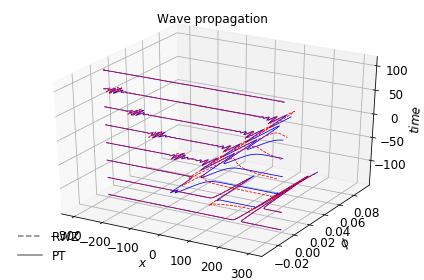

In [34]:
def plot_solution_3d():
    plot_every = 20

    times, xs, sols = solver(xmin=-300., xmax=300.,
                             nx=401, cfl=0.5, tend=600., itout=(1, 5), isout=2,
                             indexdet=400, stencilorder=2,
                             potential="PT", return_full=True)

    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    for t in times[::plot_every]:
        idx = find_nearest_index(times, t)
        z = np.zeros(xs.shape)
        z.fill(times[idx])
        # print("plotting t:{}".format(time))
        ax.plot(xs, sols[idx, :], z, color="blue", ls='-', lw=0.8)


    times, xs, sols = solver(xmin=-300., xmax=300.,
                             nx=401, cfl=0.5, tend=600., itout=(1, 5), isout=2,
                             indexdet=400, stencilorder=2,
                             potential="RWZ", return_full=True)

    for t in times[::plot_every]:
        idx = find_nearest_index(times, t)
        z = np.zeros(xs.shape)
        z.fill(times[idx])
        # print("plotting t:{}".format(time))
        ax.plot(xs, sols[idx, :], z, color="red", ls='--', lw=0.8)



    ax.plot([0., 0.], [0., 0.], color='gray', ls='--', label='RWZ')
    ax.plot([0., 0.], [0., 0.], color='gray', ls='-', label='PT')

    ax.legend(loc='lower left', shadow=False, fontsize='large', frameon=False)
    # ax.set_yscale("log")
    ax.set_xlabel("$x$", fontsize='large')
    ax.set_ylabel("$\phi$", fontsize='large')
    ax.set_zlabel("$time$", fontsize='large')
    # ax.set_ylabel()
    ax.tick_params(
        axis='both', which='both', labelleft=True,
        labelright=False, tick1On=True, tick2On=True,
        labelsize=int(12),
        direction='in',
        bottom=True, top=True, left=True, right=True
    )
    ax.minorticks_on()
    ax.set_title("Wave propagation")
    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)
    plt.savefig("./wave_3d.png", dpi=128)
    plt.tight_layout()
    plt.show()
plot_solution_3d()

### Compare the results at a extraction point

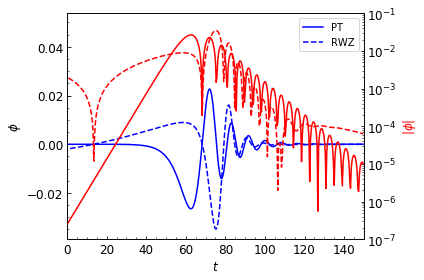

In [36]:
def task_solve_pt_plot():

    t, phi, pi = solver(xmin=-300., xmax=300.,
                        nx=401, cfl=0.5, tend=600., itout=(1,10),
                        indexdet=400, stencilorder=4, potential="PT", return_full=False)

    t2, phi2, pi2 = solver(xmin=-300., xmax=300.,
                        nx=401, cfl=0.5, tend=600., itout=(1,10),
                        indexdet=400, stencilorder=4, potential="RWZ", return_full=False)

    fig, ax1 = plt.subplots()
    ax1.plot(t, phi, '-', color='blue', label='PT')
    ax1.plot(t2, phi2, '--', color='blue', label='RWZ')
    ax1.set_xlabel(r'$t$', fontsize='large')
    ax1.set_ylabel(r'$\phi$', fontsize='large')
    ax1.legend()
    ax1.tick_params(
        axis='both', which='both', labelleft=True,
        labelright=False, tick1On=True, tick2On=False,
        labelsize=int(12),
        direction='in',
        bottom=True, top=True, left=True, right=True
    )
    ax1.minorticks_on()

    ax2 = ax1.twinx()
    ax2.semilogy(t, np.fabs(phi), '-', color='red')
    ax2.semilogy(t2, np.fabs(phi2), '--', color='red')
    ax2.set_ylabel(r'$|\phi|$', fontsize='large', color="red")
    # ax1.set_ylim([-0.04,0.05])
    ax2.set_ylim([1e-7, 1e-1])
    ax2.tick_params(
        axis='both', which='both', labelleft=False,
        labelright=True, tick1On=False, tick2On=True,
        labelsize=int(12),
        direction='in',
        bottom=True, top=True, left=True, right=True
    )
    ax2.minorticks_on()

    plt.xlim([0, 150])
    fig.tight_layout()
    # plt.savefig(FIGPATH+"extracted_at_x402.png")
    plt.show()
task_solve_pt_plot()